In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import numpy as np
import os
from utils import preprocess_images

In [2]:
from models import V as buildVision
from models import V_inverse as Decoder
from models import M as buildMemory

In [3]:
import mdn

In [4]:
from utils import load_folder

In [5]:
import matplotlib.pyplot as plt

In [6]:
V = buildVision()
V_inv = Decoder()

In [7]:
V.load_weights('weights/2019.12.07/encoder_weights')
V_inv.load_weights('weights/2019.12.07/decoder_weights')

In [8]:
V.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
enc_conv1 (Conv2D)              (None, 31, 31, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
enc_conv2 (Conv2D)              (None, 14, 14, 64)   32832       enc_conv1[0][0]                  
__________________________________________________________________________________________________
enc_conv3 (Conv2D)              (None, 6, 6, 128)    131200      enc_conv2[0][0]                  
____________________________________________________________________________________________

In [9]:
V_inv.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
dec_fc (Dense)               (None, 1024)              33792     
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 1024)        0         
_________________________________________________________________
dec_deconv1 (Conv2DTranspose (None, 5, 5, 128)         3276928   
_________________________________________________________________
dec_deconv2 (Conv2DTranspose (None, 13, 13, 64)        204864    
_________________________________________________________________
dec_deconv3 (Conv2DTranspose (None, 30, 30, 32)        73760     
_________________________________________________________________
dec_deconv4 (Conv2DTranspose (None, 64, 64, 3)         3459

In [10]:
M = buildMemory('weights/2019.12.07/mdn_rnn_weights')
get_hidden = K.function(M.layers[0].input, M.layers[0].output)

In [11]:
# tf.keras.backend.set_floatx('float64')

In [12]:
M.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 256)         299008    
_________________________________________________________________
mdn (MDN)                    (None, None, 325)         83525     
Total params: 382,533
Trainable params: 382,533
Non-trainable params: 0
_________________________________________________________________


In [12]:
class Controller():
    def __init__(self, input_size, output_size):
        self._in = input_size
        self._out = output_size
        self.W = np.random.randn(input_size, output_size)
    
    def clip(self, x, lo=0.0, hi=1.0):
        return np.minimum(np.maximum(x, lo), hi)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def __call__(self, obs):
        action = np.dot(obs, self.W)
        
        action[0] = np.tanh(action[0])
        action[1] = self.sigmoid(action[1])
        action[2] = self.clip(np.tanh(action[2]))
        
        return action
    
    def set_weights(self, W):
        # assume W is flat.
        self.W = np.reshape(W, self.W.shape)
        
    def randomly_init(self):
        self.W = np.random.randn(*self.W.shape)
       
    @property
    def shape(self):
        return self.W.shape

In [13]:
controller = Controller(32+256, 3)

In [14]:
import gym

In [15]:
env = gym.make("CarRacing-v0")

In [16]:
state = preprocess_images(env.reset())
env.close()

Track generation: 1208..1514 -> 306-tiles track


In [53]:
def rollout(controller, playback=False):
    if playback:
        ims = []
    state = preprocess_images(env.reset())
    
    M.reset_states()
    h = np.zeros(256)
    done = False
    cumulative_reward = 0
    
    while not done:
        _state = np.zeros((128, 64, 64, 3))
        _state[0] = state
        
        if playback:
            ims.append(state)
        z = V(_state)[2][0] #extract first from batch and sequence

        # combine V latent space with M hidden space 
        combined = np.concatenate([z, h], axis=0)
        
        a = controller(combined)
        
        state, reward, done, info = env.step(a)
        state = preprocess_images(state)
        
        cumulative_reward += reward

        
        # extract hidden state from LSTM
        h = get_hidden(tf.expand_dims(tf.expand_dims(np.concatenate([z, a], 0), 0), 0)).squeeze()
    
        # get factored gaussians
        # by feeding current latent_state + action
        z = M(tf.expand_dims(tf.expand_dims(np.concatenate([z, a]), 0), 0))
        
        # sample from factored gaussians
        # 32 = output_dims
        # 5  = num_mixtures
        z = np.apply_along_axis(mdn.sample_from_output, 1, z[0], 32, 5, temp=1.0).squeeze()

    env.close()
    if playback:
        return cumulative_reward, ims
    return cumulative_reward

In [21]:
import time

In [22]:
start = time.time()
rollout(controller)
end = time.time() - start

Track generation: 1098..1385 -> 287-tiles track


In [30]:
end * 50 * 10 // 3600

11.0

In [31]:
from es import SimpleGA, CMAES, PEPG, OpenES

In [32]:
NPARAMS = controller.shape[0] * controller.shape[1]
NPOPULATION = 10    # use population size of 101.
MAX_ITERATION = 50 # run each solver for 1000 generations.

In [33]:
def fit_func(params):
    controller.set_weights(params)
    reward = rollout(controller)
    return reward

In [34]:
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history.append(result[1])
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [36]:
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
oes = OpenES(NPARAMS,                  # number of model parameters
                sigma_init=0.5,            # initial standard deviation
                sigma_decay=0.999,         # don't anneal standard deviation
                learning_rate=0.1,         # learning rate for standard deviation
                learning_rate_decay = 1.0, # annealing the learning rate
                popsize=NPOPULATION,       # population size
                antithetic=False,          # whether to use antithetic sampling
                weight_decay=0.00,         # weight decay coefficient
                rank_fitness=False,        # use rank rather than fitness numbers
                forget_best=False)

In [38]:
from tqdm import tqdm

In [39]:
oes_history, result = test_solver(oes)

  0%|          | 0/50 [00:00<?, ?it/s]

Track generation: 1270..1599 -> 329-tiles track
Track generation: 1080..1354 -> 274-tiles track
Track generation: 1106..1387 -> 281-tiles track
Track generation: 1175..1473 -> 298-tiles track
Track generation: 1046..1313 -> 267-tiles track
Track generation: 1148..1439 -> 291-tiles track
Track generation: 1196..1498 -> 302-tiles track
Track generation: 1184..1484 -> 300-tiles track
Track generation: 1189..1491 -> 302-tiles track
Track generation: 1094..1379 -> 285-tiles track


  2%|▏         | 1/50 [13:50<11:18:09, 830.39s/it]

Track generation: 1470..1842 -> 372-tiles track
Track generation: 1193..1495 -> 302-tiles track
Track generation: 1215..1523 -> 308-tiles track
Track generation: 1186..1487 -> 301-tiles track
Track generation: 1112..1400 -> 288-tiles track
Track generation: 1140..1434 -> 294-tiles track
Track generation: 1283..1608 -> 325-tiles track
Track generation: 1198..1501 -> 303-tiles track
Track generation: 1216..1530 -> 314-tiles track
Track generation: 1080..1360 -> 280-tiles track


  4%|▍         | 2/50 [27:51<11:06:53, 833.61s/it]

Track generation: 1149..1441 -> 292-tiles track
Track generation: 1083..1366 -> 283-tiles track
Track generation: 1197..1505 -> 308-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1353..1695 -> 342-tiles track
Track generation: 1184..1484 -> 300-tiles track
Track generation: 1160..1454 -> 294-tiles track
Track generation: 1158..1456 -> 298-tiles track
Track generation: 1059..1328 -> 269-tiles track
Track generation: 1091..1368 -> 277-tiles track
Track generation: 1245..1560 -> 315-tiles track
Track generation: 1217..1528 -> 311-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1067..1338 -> 271-tiles track


  6%|▌         | 3/50 [41:46<10:53:18, 834.01s/it]

Track generation: 1233..1546 -> 313-tiles track
Track generation: 1176..1474 -> 298-tiles track
Track generation: 1072..1344 -> 272-tiles track
Track generation: 1101..1386 -> 285-tiles track
Track generation: 1143..1433 -> 290-tiles track
Track generation: 1154..1447 -> 293-tiles track
Track generation: 1231..1543 -> 312-tiles track
Track generation: 1097..1374 -> 277-tiles track
Track generation: 1120..1414 -> 294-tiles track
Track generation: 1050..1322 -> 272-tiles track


  8%|▊         | 4/50 [55:41<10:39:40, 834.36s/it]

Track generation: 1067..1338 -> 271-tiles track
Track generation: 1103..1383 -> 280-tiles track
Track generation: 1054..1329 -> 275-tiles track
Track generation: 1131..1418 -> 287-tiles track
Track generation: 1107..1388 -> 281-tiles track
Track generation: 1100..1386 -> 286-tiles track
Track generation: 1087..1363 -> 276-tiles track
Track generation: 1031..1293 -> 262-tiles track
Track generation: 1151..1443 -> 292-tiles track
Track generation: 1196..1499 -> 303-tiles track


 10%|█         | 5/50 [1:09:35<10:25:36, 834.13s/it]

Track generation: 1275..1598 -> 323-tiles track
Track generation: 1208..1514 -> 306-tiles track
Track generation: 1244..1559 -> 315-tiles track
Track generation: 1155..1448 -> 293-tiles track
Track generation: 1305..1641 -> 336-tiles track
Track generation: 1411..1768 -> 357-tiles track
Track generation: 1043..1308 -> 265-tiles track
Track generation: 1240..1554 -> 314-tiles track
Track generation: 1311..1643 -> 332-tiles track
Track generation: 1107..1388 -> 281-tiles track


 12%|█▏        | 6/50 [1:23:40<10:14:10, 837.51s/it]

Track generation: 1294..1624 -> 330-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1208..1514 -> 306-tiles track
Track generation: 1171..1468 -> 297-tiles track
Track generation: 1038..1311 -> 273-tiles track
Track generation: 1049..1316 -> 267-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1169..1465 -> 296-tiles track
Track generation: 1108..1389 -> 281-tiles track
Track generation: 1408..1764 -> 356-tiles track
Track generation: 1068..1339 -> 271-tiles track
Track generation: 1108..1389 -> 281-tiles track
Track generation: 1180..1479 -> 299-tiles track
Track generation: 1131..1418 -> 287-tiles track


 14%|█▍        | 7/50 [1:37:38<10:00:15, 837.57s/it]

Track generation: 1005..1260 -> 255-tiles track
Track generation: 1213..1522 -> 309-tiles track
Track generation: 1036..1299 -> 263-tiles track
Track generation: 1160..1454 -> 294-tiles track
Track generation: 1179..1478 -> 299-tiles track
Track generation: 1025..1285 -> 260-tiles track
Track generation: 1188..1490 -> 302-tiles track
Track generation: 1241..1555 -> 314-tiles track
Track generation: 1095..1373 -> 278-tiles track
Track generation: 1129..1418 -> 289-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1149..1440 -> 291-tiles track


 16%|█▌        | 8/50 [1:51:30<9:45:13, 836.04s/it] 

Track generation: 1008..1264 -> 256-tiles track
Track generation: 1129..1416 -> 287-tiles track
Track generation: 1135..1423 -> 288-tiles track
Track generation: 1403..1758 -> 355-tiles track
Track generation: 1141..1430 -> 289-tiles track
Track generation: 1147..1438 -> 291-tiles track
Track generation: 1071..1343 -> 272-tiles track
Track generation: 1211..1518 -> 307-tiles track
Track generation: 1143..1437 -> 294-tiles track
Track generation: 1122..1413 -> 291-tiles track


 18%|█▊        | 9/50 [2:05:27<9:31:21, 836.14s/it]

Track generation: 984..1237 -> 253-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 948..1194 -> 246-tiles track
Track generation: 1153..1453 -> 300-tiles track
Track generation: 1081..1355 -> 274-tiles track
Track generation: 1431..1793 -> 362-tiles track
Track generation: 1279..1603 -> 324-tiles track
Track generation: 1398..1752 -> 354-tiles track
Track generation: 1066..1337 -> 271-tiles track
Track generation: 1275..1598 -> 323-tiles track
Track generation: 1153..1445 -> 292-tiles track
Track generation: 1023..1291 -> 268-tiles track


 20%|██        | 10/50 [2:19:23<9:17:25, 836.15s/it]

Track generation: 1313..1646 -> 333-tiles track
Track generation: 1204..1509 -> 305-tiles track
Track generation: 1176..1474 -> 298-tiles track
Track generation: 1172..1469 -> 297-tiles track
Track generation: 1119..1403 -> 284-tiles track
Track generation: 1140..1429 -> 289-tiles track
Track generation: 1296..1625 -> 329-tiles track
Track generation: 1056..1324 -> 268-tiles track
Track generation: 1298..1626 -> 328-tiles track
Track generation: 1213..1526 -> 313-tiles track


 22%|██▏       | 11/50 [2:33:18<9:03:21, 835.94s/it]

Track generation: 1056..1324 -> 268-tiles track
Track generation: 1138..1434 -> 296-tiles track
Track generation: 986..1245 -> 259-tiles track
Track generation: 1116..1399 -> 283-tiles track
Track generation: 1024..1284 -> 260-tiles track
Track generation: 1180..1479 -> 299-tiles track
Track generation: 1125..1410 -> 285-tiles track
Track generation: 1435..1798 -> 363-tiles track
Track generation: 1239..1553 -> 314-tiles track
Track generation: 1120..1404 -> 284-tiles track


 24%|██▍       | 12/50 [2:47:12<8:49:04, 835.38s/it]

Track generation: 1193..1495 -> 302-tiles track
Track generation: 1138..1426 -> 288-tiles track
Track generation: 1099..1378 -> 279-tiles track
Track generation: 1147..1438 -> 291-tiles track
Track generation: 1163..1458 -> 295-tiles track
Track generation: 1133..1420 -> 287-tiles track
Track generation: 1103..1383 -> 280-tiles track
Track generation: 1045..1318 -> 273-tiles track
Track generation: 1073..1345 -> 272-tiles track
Track generation: 1179..1478 -> 299-tiles track


 26%|██▌       | 13/50 [3:00:59<8:33:36, 832.89s/it]

Track generation: 1336..1674 -> 338-tiles track
Track generation: 1134..1431 -> 297-tiles track
Track generation: 997..1258 -> 261-tiles track
Track generation: 1183..1483 -> 300-tiles track
Track generation: 1152..1443 -> 291-tiles track
Track generation: 913..1153 -> 240-tiles track
Track generation: 1208..1514 -> 306-tiles track
Track generation: 1056..1324 -> 268-tiles track
Track generation: 1286..1612 -> 326-tiles track
Track generation: 1143..1433 -> 290-tiles track


 28%|██▊       | 14/50 [3:14:55<8:20:08, 833.57s/it]

Track generation: 1046..1320 -> 274-tiles track
Track generation: 1240..1554 -> 314-tiles track
Track generation: 1092..1369 -> 277-tiles track
Track generation: 1192..1494 -> 302-tiles track
Track generation: 1045..1310 -> 265-tiles track
Track generation: 1080..1354 -> 274-tiles track
Track generation: 1197..1510 -> 313-tiles track
Track generation: 1188..1488 -> 300-tiles track
Track generation: 1248..1564 -> 316-tiles track
Track generation: 1041..1309 -> 268-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1305..1635 -> 330-tiles track


 30%|███       | 15/50 [3:28:49<8:06:27, 833.93s/it]

Track generation: 1062..1337 -> 275-tiles track
Track generation: 1179..1478 -> 299-tiles track
Track generation: 1150..1443 -> 293-tiles track
Track generation: 1119..1407 -> 288-tiles track
Track generation: 1278..1608 -> 330-tiles track
Track generation: 1204..1508 -> 304-tiles track
Track generation: 1116..1399 -> 283-tiles track
Track generation: 1327..1664 -> 337-tiles track
Track generation: 1092..1369 -> 277-tiles track
Track generation: 1213..1527 -> 314-tiles track


 32%|███▏      | 16/50 [3:42:52<7:54:02, 836.53s/it]

Track generation: 1307..1638 -> 331-tiles track
Track generation: 1179..1478 -> 299-tiles track
Track generation: 1180..1479 -> 299-tiles track
Track generation: 1175..1475 -> 300-tiles track
Track generation: 1170..1466 -> 296-tiles track
Track generation: 1208..1519 -> 311-tiles track
Track generation: 1151..1443 -> 292-tiles track
Track generation: 1116..1400 -> 284-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1225..1535 -> 310-tiles track
Track generation: 1117..1400 -> 283-tiles track
Track generation: 1022..1284 -> 262-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1082..1356 -> 274-tiles track


 34%|███▍      | 17/50 [3:56:49<7:40:05, 836.52s/it]

Track generation: 1076..1349 -> 273-tiles track
Track generation: 1152..1444 -> 292-tiles track
Track generation: 1047..1322 -> 275-tiles track
Track generation: 1263..1583 -> 320-tiles track
Track generation: 1080..1354 -> 274-tiles track
Track generation: 1145..1435 -> 290-tiles track
Track generation: 1306..1636 -> 330-tiles track
Track generation: 1048..1319 -> 271-tiles track
Track generation: 1171..1468 -> 297-tiles track
Track generation: 1207..1513 -> 306-tiles track


 36%|███▌      | 18/50 [4:10:44<7:25:59, 836.23s/it]

Track generation: 1309..1640 -> 331-tiles track
Track generation: 1174..1472 -> 298-tiles track
Track generation: 1144..1441 -> 297-tiles track
Track generation: 1194..1496 -> 302-tiles track
Track generation: 1196..1499 -> 303-tiles track
Track generation: 1109..1398 -> 289-tiles track
Track generation: 1204..1517 -> 313-tiles track
Track generation: 1001..1265 -> 264-tiles track
Track generation: 1195..1498 -> 303-tiles track
Track generation: 1093..1370 -> 277-tiles track


 38%|███▊      | 19/50 [4:24:43<7:12:25, 836.95s/it]

Track generation: 1215..1523 -> 308-tiles track
Track generation: 1002..1266 -> 264-tiles track
Track generation: 1188..1489 -> 301-tiles track
Track generation: 1184..1484 -> 300-tiles track
Track generation: 1160..1455 -> 295-tiles track
Track generation: 1155..1448 -> 293-tiles track
Track generation: 1162..1461 -> 299-tiles track
Track generation: 1164..1459 -> 295-tiles track
Track generation: 1301..1630 -> 329-tiles track
Track generation: 1327..1663 -> 336-tiles track


 40%|████      | 20/50 [4:38:47<6:59:34, 839.13s/it]

Track generation: 1145..1435 -> 290-tiles track
Track generation: 1098..1378 -> 280-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1113..1404 -> 291-tiles track
Track generation: 1138..1427 -> 289-tiles track
Track generation: 1089..1369 -> 280-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1060..1329 -> 269-tiles track
Track generation: 1100..1380 -> 280-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 991..1243 -> 252-tiles track
Track generation: 1281..1605 -> 324-tiles track
Track generation: 1184..1484 -> 300-tiles track
Track generation: 1220..1529 -> 309-tiles track
Track generation: 1238..1592 -> 354-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1026..1291 -> 265-tiles track
Track generation: 1032..1294 -> 262-tiles track


 42%|████▏     | 21/50 [4:52:46<6:45:34, 839.12s/it]

Track generation: 1213..1521 -> 308-tiles track
Track generation: 1310..1643 -> 333-tiles track
Track generation: 1248..1564 -> 316-tiles track
Track generation: 1156..1449 -> 293-tiles track
Track generation: 1359..1703 -> 344-tiles track
Track generation: 1147..1438 -> 291-tiles track
Track generation: 1016..1279 -> 263-tiles track
Track generation: 1205..1511 -> 306-tiles track
Track generation: 1336..1674 -> 338-tiles track
Track generation: 1012..1278 -> 266-tiles track


 44%|████▍     | 22/50 [5:06:53<6:32:38, 841.37s/it]

Track generation: 1011..1268 -> 257-tiles track
Track generation: 1040..1310 -> 270-tiles track
Track generation: 1155..1448 -> 293-tiles track
Track generation: 1146..1442 -> 296-tiles track
Track generation: 1396..1749 -> 353-tiles track
Track generation: 1220..1529 -> 309-tiles track
Track generation: 1211..1517 -> 306-tiles track
Track generation: 1156..1449 -> 293-tiles track
Track generation: 1191..1493 -> 302-tiles track
Track generation: 1067..1338 -> 271-tiles track


 46%|████▌     | 23/50 [5:20:56<6:18:51, 841.91s/it]

Track generation: 1035..1305 -> 270-tiles track
Track generation: 1096..1374 -> 278-tiles track
Track generation: 1190..1490 -> 300-tiles track
Track generation: 1175..1473 -> 298-tiles track
Track generation: 1160..1454 -> 294-tiles track
Track generation: 1213..1523 -> 310-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1155..1448 -> 293-tiles track
Track generation: 1168..1464 -> 296-tiles track
Track generation: 1090..1372 -> 282-tiles track
Track generation: 1250..1566 -> 316-tiles track
Track generation: 1119..1403 -> 284-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1036..1299 -> 263-tiles track


 48%|████▊     | 24/50 [5:34:53<6:04:12, 840.49s/it]

Track generation: 1219..1528 -> 309-tiles track
Track generation: 1164..1469 -> 305-tiles track
Track generation: 1288..1614 -> 326-tiles track
Track generation: 1079..1353 -> 274-tiles track
Track generation: 1208..1514 -> 306-tiles track
Track generation: 1244..1559 -> 315-tiles track
Track generation: 1046..1316 -> 270-tiles track
Track generation: 1296..1624 -> 328-tiles track
Track generation: 1251..1568 -> 317-tiles track
Track generation: 1103..1383 -> 280-tiles track


 50%|█████     | 25/50 [5:49:00<5:50:58, 842.32s/it]

Track generation: 1128..1422 -> 294-tiles track
Track generation: 1084..1359 -> 275-tiles track
Track generation: 1181..1482 -> 301-tiles track
Track generation: 1086..1362 -> 276-tiles track
Track generation: 1071..1343 -> 272-tiles track
Track generation: 1182..1482 -> 300-tiles track
Track generation: 1195..1497 -> 302-tiles track
Track generation: 1288..1614 -> 326-tiles track
Track generation: 1165..1460 -> 295-tiles track
Track generation: 1016..1274 -> 258-tiles track


 52%|█████▏    | 26/50 [6:03:00<5:36:45, 841.88s/it]

Track generation: 1171..1472 -> 301-tiles track
Track generation: 1207..1513 -> 306-tiles track
Track generation: 1011..1270 -> 259-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1098..1375 -> 277-tiles track
Track generation: 1125..1417 -> 292-tiles track
Track generation: 1172..1469 -> 297-tiles track
Track generation: 991..1245 -> 254-tiles track
Track generation: 1077..1350 -> 273-tiles track
Track generation: 991..1247 -> 256-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1171..1468 -> 297-tiles track
Track generation: 1239..1553 -> 314-tiles track
Track generation: 1167..1463 -> 296-tiles track


 54%|█████▍    | 27/50 [6:17:04<5:22:55, 842.41s/it]

Track generation: 1059..1328 -> 269-tiles track
Track generation: 1176..1474 -> 298-tiles track
Track generation: 1232..1544 -> 312-tiles track
Track generation: 949..1195 -> 246-tiles track
Track generation: 1016..1282 -> 266-tiles track
Track generation: 1043..1308 -> 265-tiles track
Track generation: 1144..1440 -> 296-tiles track
Track generation: 997..1259 -> 262-tiles track
Track generation: 1183..1483 -> 300-tiles track
Track generation: 1164..1459 -> 295-tiles track


 56%|█████▌    | 28/50 [6:31:05<5:08:46, 842.12s/it]

Track generation: 1125..1418 -> 293-tiles track
Track generation: 1171..1468 -> 297-tiles track
Track generation: 1051..1318 -> 267-tiles track
Track generation: 1206..1512 -> 306-tiles track
Track generation: 1205..1510 -> 305-tiles track
Track generation: 1177..1475 -> 298-tiles track
Track generation: 992..1247 -> 255-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1062..1340 -> 278-tiles track
Track generation: 1086..1361 -> 275-tiles track
Track generation: 1024..1289 -> 265-tiles track
Track generation: 1363..1708 -> 345-tiles track


 58%|█████▊    | 29/50 [6:45:09<4:54:54, 842.60s/it]

Track generation: 1196..1499 -> 303-tiles track
Track generation: 1007..1263 -> 256-tiles track
Track generation: 1085..1360 -> 275-tiles track
Track generation: 1131..1418 -> 287-tiles track
Track generation: 1219..1528 -> 309-tiles track
Track generation: 1047..1320 -> 273-tiles track
Track generation: 1034..1305 -> 271-tiles track
Track generation: 1051..1326 -> 275-tiles track
Track generation: 1142..1431 -> 289-tiles track
Track generation: 1350..1692 -> 342-tiles track


 60%|██████    | 30/50 [6:59:09<4:40:36, 841.81s/it]

Track generation: 1124..1409 -> 285-tiles track
Track generation: 1098..1376 -> 278-tiles track
Track generation: 1087..1368 -> 281-tiles track
Track generation: 1033..1295 -> 262-tiles track
Track generation: 892..1125 -> 233-tiles track
Track generation: 1201..1505 -> 304-tiles track
Track generation: 1118..1402 -> 284-tiles track
Track generation: 1252..1569 -> 317-tiles track
Track generation: 1245..1560 -> 315-tiles track
Track generation: 1142..1436 -> 294-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1146..1436 -> 290-tiles track


 62%|██████▏   | 31/50 [7:13:09<4:26:23, 841.26s/it]

Track generation: 1124..1408 -> 284-tiles track
Track generation: 1244..1559 -> 315-tiles track
Track generation: 1190..1492 -> 302-tiles track
Track generation: 1206..1517 -> 311-tiles track
Track generation: 1259..1577 -> 318-tiles track
Track generation: 1079..1353 -> 274-tiles track
Track generation: 1027..1297 -> 270-tiles track
Track generation: 1123..1408 -> 285-tiles track
Track generation: 1200..1511 -> 311-tiles track
Track generation: 1272..1594 -> 322-tiles track


 64%|██████▍   | 32/50 [7:27:22<4:13:26, 844.78s/it]

Track generation: 987..1240 -> 253-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1302..1631 -> 329-tiles track
Track generation: 1160..1454 -> 294-tiles track
Track generation: 1299..1628 -> 329-tiles track
Track generation: 1168..1464 -> 296-tiles track
Track generation: 1192..1504 -> 312-tiles track
Track generation: 1199..1503 -> 304-tiles track
Track generation: 1206..1512 -> 306-tiles track
Track generation: 1065..1335 -> 270-tiles track
Track generation: 1200..1504 -> 304-tiles track
Track generation: 1328..1664 -> 336-tiles track


 66%|██████▌   | 33/50 [7:41:43<4:00:44, 849.67s/it]

Track generation: 1018..1284 -> 266-tiles track
Track generation: 1088..1364 -> 276-tiles track
Track generation: 1011..1268 -> 257-tiles track
Track generation: 1115..1398 -> 283-tiles track
Track generation: 1126..1415 -> 289-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1035..1298 -> 263-tiles track
Track generation: 1139..1436 -> 297-tiles track
Track generation: 1105..1385 -> 280-tiles track
Track generation: 1047..1319 -> 272-tiles track
Track generation: 1030..1298 -> 268-tiles track
Track generation: 1426..1787 -> 361-tiles track


 68%|██████▊   | 34/50 [7:55:54<3:46:40, 850.05s/it]

Track generation: 1271..1593 -> 322-tiles track
Track generation: 1163..1458 -> 295-tiles track
Track generation: 928..1164 -> 236-tiles track
Track generation: 1460..1829 -> 369-tiles track
Track generation: 1186..1486 -> 300-tiles track
Track generation: 1111..1400 -> 289-tiles track
Track generation: 1158..1452 -> 294-tiles track
Track generation: 1203..1508 -> 305-tiles track
Track generation: 1128..1414 -> 286-tiles track
Track generation: 1182..1488 -> 306-tiles track


 70%|███████   | 35/50 [8:10:11<3:33:02, 852.13s/it]

Track generation: 1110..1392 -> 282-tiles track
Track generation: 1184..1484 -> 300-tiles track
Track generation: 1043..1315 -> 272-tiles track
Track generation: 1192..1491 -> 299-tiles track
Track generation: 981..1230 -> 249-tiles track
Track generation: 1148..1439 -> 291-tiles track
Track generation: 1196..1499 -> 303-tiles track
Track generation: 1175..1482 -> 307-tiles track
Track generation: 1079..1353 -> 274-tiles track
Track generation: 1132..1419 -> 287-tiles track


 72%|███████▏  | 36/50 [8:24:26<3:19:00, 852.88s/it]

Track generation: 1178..1483 -> 305-tiles track
Track generation: 1272..1594 -> 322-tiles track
Track generation: 1084..1359 -> 275-tiles track
Track generation: 1297..1626 -> 329-tiles track
Track generation: 1204..1508 -> 304-tiles track
Track generation: 1164..1459 -> 295-tiles track
Track generation: 1305..1646 -> 341-tiles track
Track generation: 1128..1414 -> 286-tiles track
Track generation: 1060..1335 -> 275-tiles track
Track generation: 1113..1395 -> 282-tiles track


 74%|███████▍  | 37/50 [8:38:47<3:05:18, 855.25s/it]

Track generation: 1158..1455 -> 297-tiles track
Track generation: 1111..1393 -> 282-tiles track
Track generation: 1202..1507 -> 305-tiles track
Track generation: 1261..1588 -> 327-tiles track
Track generation: 1148..1439 -> 291-tiles track
Track generation: 1292..1619 -> 327-tiles track
Track generation: 1144..1434 -> 290-tiles track
Track generation: 1052..1328 -> 276-tiles track
Track generation: 1214..1530 -> 316-tiles track
Track generation: 1200..1504 -> 304-tiles track


 76%|███████▌  | 38/50 [8:53:06<2:51:19, 856.64s/it]

Track generation: 1193..1495 -> 302-tiles track
Track generation: 1157..1450 -> 293-tiles track
Track generation: 1052..1323 -> 271-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1248..1564 -> 316-tiles track
Track generation: 1108..1389 -> 281-tiles track
Track generation: 1199..1503 -> 304-tiles track
Track generation: 1155..1448 -> 293-tiles track
Track generation: 1185..1485 -> 300-tiles track
Track generation: 1025..1293 -> 268-tiles track
Track generation: 1216..1524 -> 308-tiles track
Track generation: 1248..1564 -> 316-tiles track


 78%|███████▊  | 39/50 [9:07:29<2:37:22, 858.42s/it]

Track generation: 1233..1545 -> 312-tiles track
Track generation: 1181..1480 -> 299-tiles track
Track generation: 1374..1721 -> 347-tiles track
Track generation: 1014..1271 -> 257-tiles track
Track generation: 1087..1363 -> 276-tiles track
Track generation: 1193..1503 -> 310-tiles track
Track generation: 1142..1439 -> 297-tiles track
Track generation: 1151..1443 -> 292-tiles track
Track generation: 1091..1368 -> 277-tiles track
Track generation: 1192..1494 -> 302-tiles track


 80%|████████  | 40/50 [9:21:54<2:23:24, 860.42s/it]

Track generation: 934..1180 -> 246-tiles track
Track generation: 1157..1456 -> 299-tiles track
Track generation: 1014..1272 -> 258-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1111..1400 -> 289-tiles track
Track generation: 1072..1344 -> 272-tiles track
Track generation: 1212..1519 -> 307-tiles track
Track generation: 1336..1674 -> 338-tiles track
Track generation: 1283..1608 -> 325-tiles track
Track generation: 1031..1293 -> 262-tiles track
Track generation: 1197..1500 -> 303-tiles track
Track generation: 1185..1485 -> 300-tiles track


 82%|████████▏ | 41/50 [9:36:12<2:08:58, 859.78s/it]

Track generation: 1152..1444 -> 292-tiles track
Track generation: 1044..1309 -> 265-tiles track
Track generation: 1135..1423 -> 288-tiles track
Track generation: 1311..1643 -> 332-tiles track
Track generation: 1179..1478 -> 299-tiles track
Track generation: 1130..1424 -> 294-tiles track
Track generation: 1064..1334 -> 270-tiles track
Track generation: 1101..1380 -> 279-tiles track
Track generation: 1012..1276 -> 264-tiles track
Track generation: 1216..1525 -> 309-tiles track


 84%|████████▍ | 42/50 [9:50:37<1:54:50, 861.33s/it]

Track generation: 1206..1511 -> 305-tiles track
Track generation: 1241..1556 -> 315-tiles track
Track generation: 1228..1539 -> 311-tiles track
Track generation: 1196..1507 -> 311-tiles track
Track generation: 1135..1423 -> 288-tiles track
Track generation: 1079..1353 -> 274-tiles track
Track generation: 1199..1506 -> 307-tiles track
Track generation: 1112..1394 -> 282-tiles track
Track generation: 1235..1548 -> 313-tiles track
Track generation: 1232..1544 -> 312-tiles track


 86%|████████▌ | 43/50 [10:05:06<1:40:44, 863.55s/it]

Track generation: 1121..1412 -> 291-tiles track
Track generation: 1148..1439 -> 291-tiles track
Track generation: 1261..1588 -> 327-tiles track
Track generation: 1117..1400 -> 283-tiles track
Track generation: 1068..1348 -> 280-tiles track
Track generation: 1104..1384 -> 280-tiles track
Track generation: 1073..1345 -> 272-tiles track
Track generation: 1106..1387 -> 281-tiles track
Track generation: 1048..1314 -> 266-tiles track
Track generation: 1169..1465 -> 296-tiles track


 88%|████████▊ | 44/50 [10:19:28<1:26:18, 863.06s/it]

Track generation: 1233..1546 -> 313-tiles track
Track generation: 1073..1354 -> 281-tiles track
Track generation: 1084..1364 -> 280-tiles track
Track generation: 1203..1518 -> 315-tiles track
Track generation: 1139..1428 -> 289-tiles track
Track generation: 1248..1564 -> 316-tiles track
Track generation: 1295..1623 -> 328-tiles track
Track generation: 1233..1546 -> 313-tiles track
Track generation: 1203..1508 -> 305-tiles track
Track generation: 1090..1366 -> 276-tiles track


 90%|█████████ | 45/50 [10:33:55<1:12:01, 864.23s/it]

Track generation: 1119..1403 -> 284-tiles track
Track generation: 1180..1479 -> 299-tiles track
Track generation: 1187..1494 -> 307-tiles track
Track generation: 1081..1355 -> 274-tiles track
Track generation: 1028..1289 -> 261-tiles track
Track generation: 1158..1451 -> 293-tiles track
Track generation: 1147..1438 -> 291-tiles track
Track generation: 928..1200 -> 272-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1055..1323 -> 268-tiles track
Track generation: 1110..1400 -> 290-tiles track
Track generation: 1040..1304 -> 264-tiles track


 92%|█████████▏| 46/50 [10:47:58<57:11, 857.83s/it]  

Track generation: 1265..1585 -> 320-tiles track
Track generation: 1238..1553 -> 315-tiles track
Track generation: 1192..1494 -> 302-tiles track
Track generation: 1107..1388 -> 281-tiles track
Track generation: 1013..1279 -> 266-tiles track
Track generation: 1128..1414 -> 286-tiles track
Track generation: 1080..1359 -> 279-tiles track
Track generation: 1083..1358 -> 275-tiles track
Track generation: 1076..1349 -> 273-tiles track
Track generation: 1120..1404 -> 284-tiles track


 94%|█████████▍| 47/50 [11:02:02<42:41, 853.84s/it]

Track generation: 1272..1604 -> 332-tiles track
Track generation: 1166..1462 -> 296-tiles track
Track generation: 1163..1458 -> 295-tiles track
Track generation: 1247..1563 -> 316-tiles track
Track generation: 1233..1545 -> 312-tiles track
Track generation: 1011..1276 -> 265-tiles track
Track generation: 1071..1343 -> 272-tiles track
Track generation: 1095..1373 -> 278-tiles track
Track generation: 1224..1534 -> 310-tiles track
Track generation: 1228..1541 -> 313-tiles track


 96%|█████████▌| 48/50 [11:16:17<28:28, 854.17s/it]

Track generation: 1160..1454 -> 294-tiles track
Track generation: 1135..1423 -> 288-tiles track
Track generation: 1220..1529 -> 309-tiles track
Track generation: 1173..1471 -> 298-tiles track
Track generation: 1113..1403 -> 290-tiles track
Track generation: 1119..1403 -> 284-tiles track
Track generation: 1136..1424 -> 288-tiles track
Track generation: 1195..1498 -> 303-tiles track
Track generation: 1061..1331 -> 270-tiles track
Track generation: 1111..1393 -> 282-tiles track


 98%|█████████▊| 49/50 [11:30:21<14:11, 851.13s/it]

Track generation: 1121..1405 -> 284-tiles track
Track generation: 1029..1293 -> 264-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1196..1499 -> 303-tiles track
Track generation: 1098..1376 -> 278-tiles track
Track generation: 1108..1389 -> 281-tiles track
Track generation: 1160..1454 -> 294-tiles track
Track generation: 1118..1406 -> 288-tiles track
Track generation: 1175..1473 -> 298-tiles track
Track generation: 1148..1438 -> 290-tiles track
Track generation: 1094..1372 -> 278-tiles track
Track generation: 1260..1589 -> 329-tiles track


100%|██████████| 50/50 [11:44:29<00:00, 845.38s/it]

local optimum discovered by solver:
 [ 6.30003499e-01  4.51197340e-01  1.70887273e-01 -9.05499179e-01
  8.71563685e-02 -1.82578603e-01  4.79701444e-02  5.82443222e-01
  4.59429750e-01  2.38981768e-01  1.22423216e-01  6.43585727e-01
  3.79085750e-01  5.21840848e-01  3.94712006e-01 -6.26844881e-01
 -1.20248008e-01 -5.66957063e-01 -9.87332054e-02  7.41268523e-01
 -8.26846385e-01 -8.76717804e-02  5.82328110e-01  7.79535670e-01
  2.17984677e-01  3.35982331e-01 -5.70940414e-01 -1.49924342e-01
 -1.89325711e-01 -4.67248711e-01  9.17561893e-02  6.50800238e-02
 -3.19925400e-01 -4.21788921e-02  7.02810870e-03  1.12798999e-01
  9.53500718e-02  2.12952691e-01  4.04835389e-01 -5.61038478e-01
 -1.00934679e-01 -2.59134817e-01  6.41496842e-01 -3.83671800e-02
 -2.57107422e-01 -6.11677207e-02 -1.23834109e-01  2.90073294e-01
  8.80671877e-02  1.27694478e-02 -3.70373231e-01 -5.45986737e-01
  2.56161592e-01  4.90510750e-01 -5.94112754e-01  3.41227682e-01
 -3.47886661e-01 -5.25390141e-01  8.16530601e-01  1.3

In [50]:
result[3]

0.47560281409851574

In [51]:
controller.set_weights(result[0])

In [62]:
np.save('./weights/C_weights.npy', controller.W)

In [ ]:
env.close()

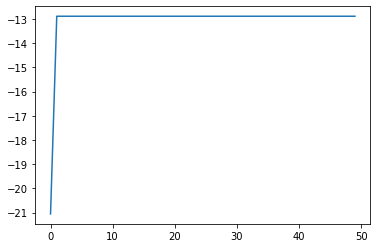

In [52]:
plt.plot(oes_history)

In [55]:
r, playback = rollout(controller, playback=True)

Track generation: 1047..1313 -> 266-tiles track


In [56]:
import matplotlib.pyplot as plt
from IPython import display

In [57]:
def show_state(env, step=0, name="", info="", image=None):
    """Fn to visualize the agent playing the game in a notebook
    """
    plt.figure(10)
    plt.clf()
    if image is not None:
        im = image
    else:
        im = env.render(mode="rgb_array")[0]
    plt.imshow(im)
    plt.title("{} | Step: {} {}".format(name, step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

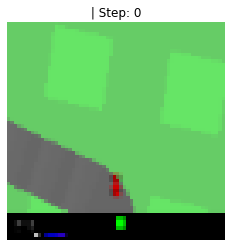

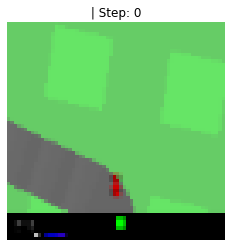

In [59]:
for i in playback:
    show_state(None, image=i[0])

In [61]:
np.save("AICAR.npy", playback)